In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold
import numpy as np
import sklearn.metrics as skm

#### Создание первой модели

In [36]:
data = pd.read_csv("Admission_Predict_Ver1.1.csv")
data.shape

(500, 9)

In [37]:
del data["Serial No."]
pd.concat({'Object type':data.dtypes, 'Null count':data.isnull().sum()}, axis=1)

,Object type,Null count
GRE Score,int64,0
TOEFL Score,int64,0
University Rating,int64,0
SOP,float64,0
LOR,float64,0
CGPA,float64,0
Research,int64,0
Chance of Admit,float64,0


In [38]:
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


За целевой признак принимаю последний столбец: "Chance of Admit"\
Это вероятность зачисления студента, диапазон [0, 1]

Перед нами задача регрессии.

Построим матрицу корреляции и выберем признаки для построения модели.

In [33]:
data.corr()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL Score,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
University Rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance of Admit,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


Уберем признак Research как самый невлияющих в сравнении с остальными.\

In [ ]:
del data['Research']

Выполним масштабирование данных.

In [45]:
# Отделяем целевой признак от данных
features = data.iloc[:, :-1]
#del features['Research']
targets = data.iloc[:, -1]

scaler = MinMaxScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

Проверим, что данные по первому столбцу масштабировались корректно

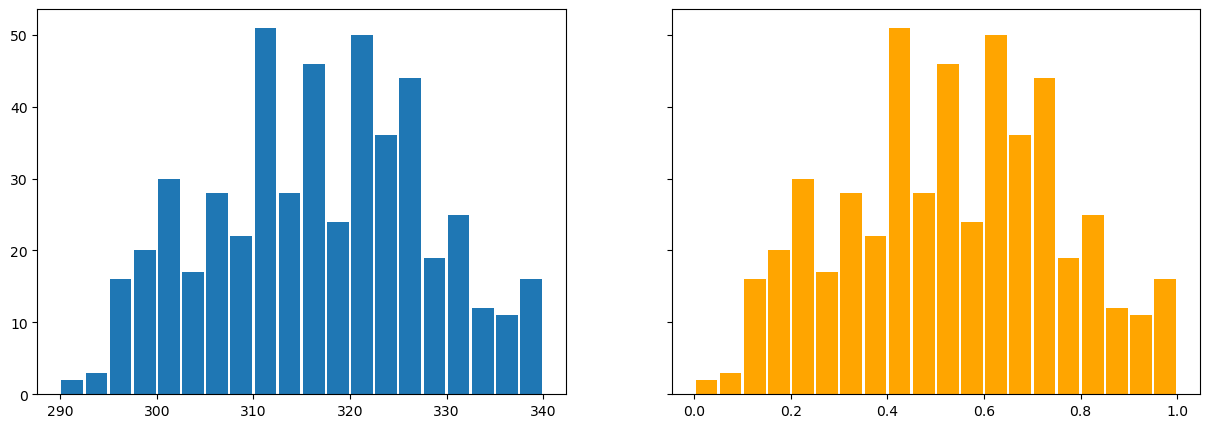

In [46]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
ax[0].hist(features['GRE Score'], rwidth=0.9, bins=20)
ax[1].hist(features_scaled[:,0], rwidth=0.9, bins=20, color='orange')
plt.show()

Выполним разбиение данных на обучающую и тестовую выборки.

In [51]:
# Делим выборку
data_train, data_test, target_train, target_test = train_test_split(features_scaled, targets, test_size=0.2)

Создадим регрессор и предскажем значения для тестовой выборки

In [52]:
# Возьмем кол-во соседей 5 (наиболее часто используемое значение)
regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(data_train, target_train)
prediction = regressor.predict(data_test)
print(prediction, target_test, sep='\n')

[0.656 0.934 0.668 0.926 0.592 0.624 0.634 0.926 0.768 0.868 0.552 0.91
 0.664 0.8   0.874 0.652 0.89  0.65  0.9   0.528 0.738 0.736 0.64  0.802
 0.658 0.63  0.532 0.568 0.626 0.806 0.734 0.702 0.46  0.744 0.808 0.582
 0.518 0.756 0.782 0.864 0.692 0.798 0.634 0.934 0.554 0.612 0.752 0.9
 0.544 0.642 0.768 0.692 0.71  0.53  0.942 0.768 0.662 0.65  0.92  0.858
 0.784 0.906 0.584 0.688 0.684 0.658 0.82  0.696 0.604 0.742 0.71  0.61
 0.73  0.874 0.736 0.7   0.824 0.624 0.796 0.706 0.938 0.848 0.688 0.692
 0.678 0.746 0.8   0.762 0.914 0.66  0.634 0.658 0.694 0.76  0.558 0.7
 0.61  0.846 0.704 0.72 ]
494    0.68
22     0.94
55     0.64
187    0.93
332    0.75
       ... 
321    0.73
179    0.73
12     0.78
350    0.74
198    0.70
Name: Chance of Admit , Length: 100, dtype: float64


Оценим качество модели.

In [53]:
print(skm.mean_absolute_error(target_test, prediction)) # MAE
print(skm.mean_squared_error(target_test, prediction, squared=False)) # RMSE

0.0492
0.06520184046482123


#### Подбор гиперпараметра K с GridSeachCV

In [82]:
n_range = np.array(range(2, 40, 2))
params = [{'n_neighbors': n_range}]
params

[{'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
         36, 38])}]

In [83]:
opt = GridSearchCV(KNeighborsRegressor(), params, cv=5, scoring='neg_mean_absolute_error')
opt.fit(data_train, target_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38])}],
             scoring='neg_mean_absolute_error')

In [84]:
opt.best_params_, opt.best_score_

({'n_neighbors': 12}, -0.04792916666666667)

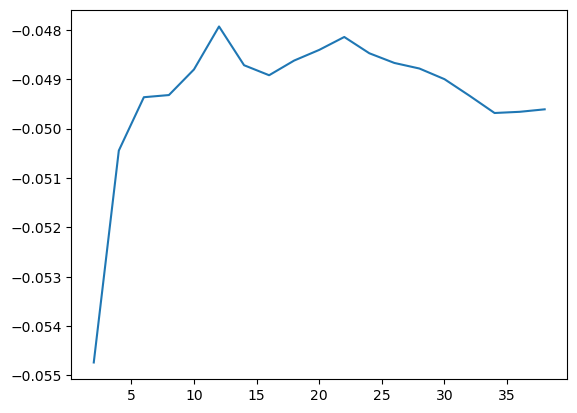

In [85]:
plt.plot(n_range, opt.cv_results_['mean_test_score'])

#### Подбор гиперпараметра K с RandomizedSearchCV

In [101]:
n_range = np.array(range(2, 40, 2))
params = [{'n_neighbors': n_range}]
params

[{'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
         36, 38])}]

Используем другой метод кросс-валидации: RepeatedKFold

In [102]:
rkf = RepeatedKFold(n_splits=3, n_repeats=5)

In [103]:
opt = RandomizedSearchCV(KNeighborsRegressor(), params, cv=rkf, scoring='neg_mean_absolute_error')
opt.fit(data_train, target_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=3, random_state=None),
                   estimator=KNeighborsRegressor(),
                   param_distributions=[{'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38])}],
                   scoring='neg_mean_absolute_error')

In [104]:
opt.best_params_, opt.best_score_

({'n_neighbors': 10}, -0.04859621441663862)

#### Сравнение с исходной моделью

Видим, что из двух оптимизаций гиперпараметра K лучшим результатом обладает K = 12\
С результатом MAE = -0.48

Сравним с исходной моделью при K = 5:

In [94]:
skm.mean_absolute_error(target_test, prediction) # MAE

0.0492